In [38]:
from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

# Data Preparation

In [39]:
import glob2
from PIL import Image
import matplotlib.image as mpimg

fish_image_files = glob2.glob('train/**/*.jpg')
albacore_image_list = []
size = 300, 300


### Read Data as Numpy Arrays, Resize, and Color B&W

In [40]:
igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])

### Linearize and Visualize Images

In [41]:
train_data = igs.astype('float32')
train_data = train_data / 255
igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))

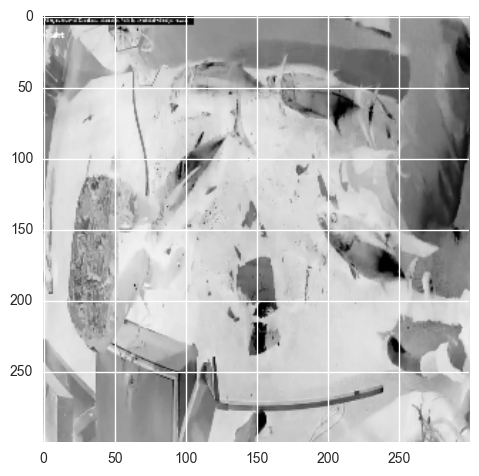

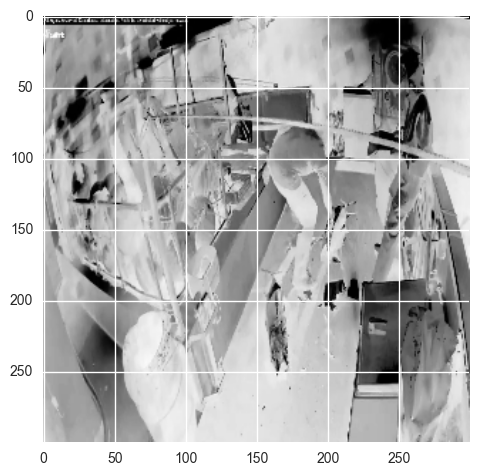

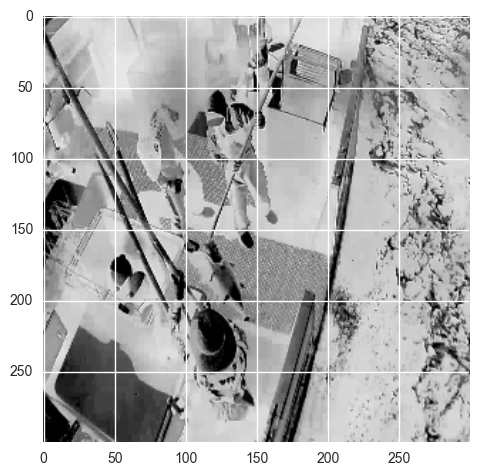

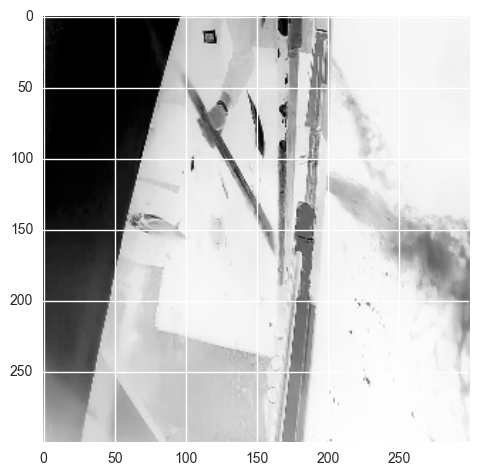

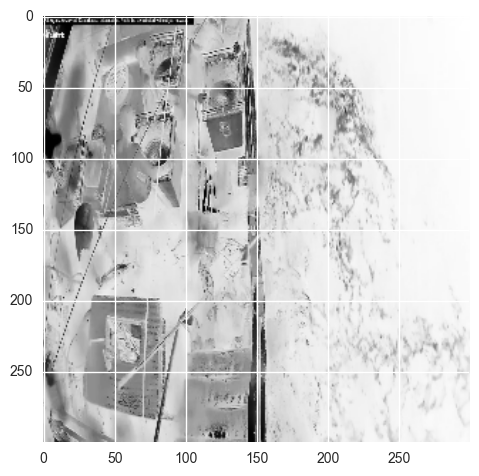

In [43]:
for i in range(0,5):
    plt.imshow(igs[i])
    plt.show()

# Data Reduction

### Linear Dimensionality Reduction Using Principal Component Analysis

In [44]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfaces = pca.components_.reshape((n_components, train_data.shape[1]*train_data.shape[2]))

Extracting the top 173 eigenfishes from 7554 fishes
CPU times: user 17min 20s, sys: 45.3 s, total: 18min 5s
Wall time: 5min 13s


In [45]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [46]:
plot_explained_variance(pca)

##### __ dimensions are required to adequately represent our image data. 

### Non-Linear Dimensionality Reduction of Image Data

In [47]:
n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (n_components, igs.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(igs_pca)


Extracting the top 173 eigenfishes from 7554 fishes
CPU times: user 5min 14s, sys: 10.5 s, total: 5min 24s
Wall time: 1min 51s


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=173,
     remove_zero_eig=False, tol=0)

In [48]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods
X = igs_pca
n_samples, n_features = igs_pca.shape
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    plt.show()


In [49]:
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

<function __main__.plt_reconstruct>

We prefer non-linear dimensions to linear dimensions because of the higher clarity. 

### Feature Extraction Techniques

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning:

Low image dynamic range; displaying image with stretched contrast.



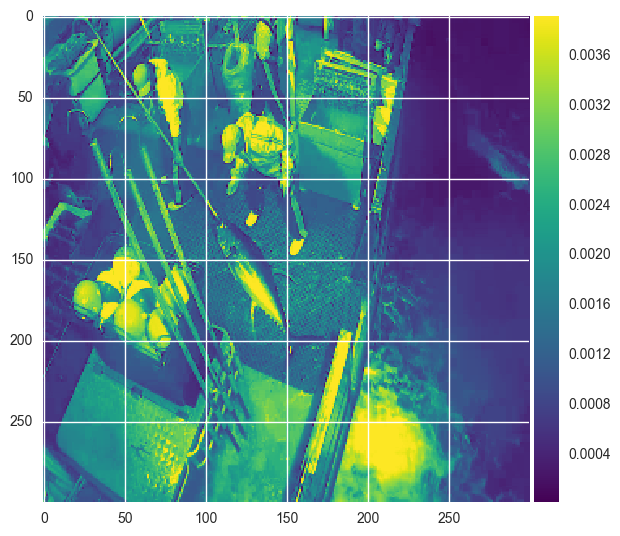

In [50]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2]))
imshow(img)
plt.grid()
plt.show()

#### Ordered Gradients

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning:

Low image dynamic range; displaying image with stretched contrast.



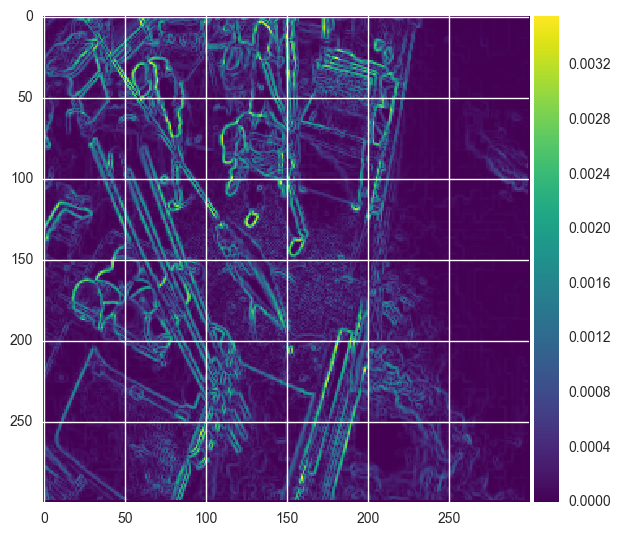

In [51]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()
plt.show()

#### DAISY Bag of Features Model

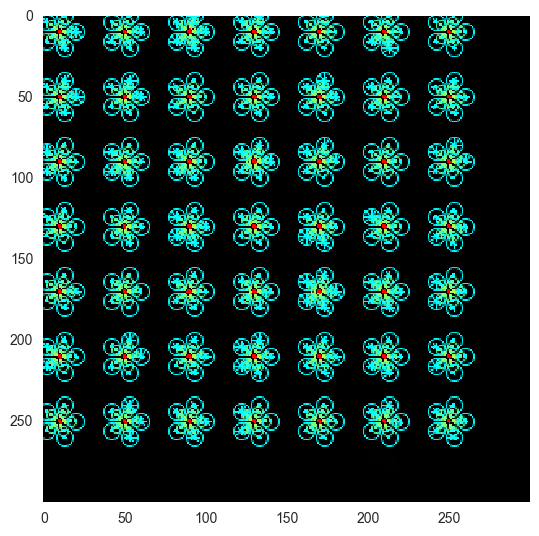

In [52]:
from skimage.feature import daisy

features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

In [53]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(28, 28, 72)
56448


In [60]:
from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Next Closest Image ")
    plt.grid()
    plt.show()

In [61]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(train_data.shape[1], train_data.shape[2]))

CPU times: user 552 ms, sys: 154 ms, total: 706 ms
Wall time: 721 ms


(81536,)

In [ ]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (train_data.shape[1], train_data.shape[2]))
print(daisy_features.shape)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

In [ ]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

#### Gabor Filters

In [ ]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, ((train_data.shape[1], train_data.shape[2])))
gabr_feature

In [ ]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (train_data.shape[1], train_data.shape[2]))
print(gabor_stats.shape)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
%time dist_matrix = pairwise_distances(gabor_stats)

In [ ]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

### Visualizing Differences in Target Classes

In [ ]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

In [ ]:
plt.imshow(dist_matrix)
plt.colorbar()
plt.show()
